# Tensorcom

# Tensorcom

- decompression, preprocessing, and loading often create bottlenecks
    - e.g., PyTorch `DataLoader` with workers is limited to a single machine
- `Tensorcom` permits distributed preprocessing
- also permits RDMA, PUB/SUB
- uses a GPU-friendly, simple binary encoding
- makes preprocessing independent of DL framework

$N \times$ Storage Server $\rightarrow$ $M \times$ Tensorcom Process $\rightarrow$ $G \times$ GPU machines

$N$, $M$, and $G$ can be independently scaled

In [1]:
%pylab inline
!date; hostname; whoami; pwd; curl https://ipinfo.io/hostname; nvidia-smi -L
from imp import reload
from torch import nn, optim
from torch.nn import functional as F
from torchmore import layers, flex
import torch
from torchvision import datasets, transforms
from torchvision.datasets import imagenet
import os.path
from torch.utils import data as torchdata
import helpers
import tensorcom as tc

Populating the interactive namespace from numpy and matplotlib
Sun Dec  8 04:03:45 UTC 2019
tmbcomp
tmb
/home/tmb/exp/bigdata19
158.153.83.34.bc.googleusercontent.com
GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-ffa2b7fc-dde2-eb1c-7481-861ea0f181a3)
GPU 1: Tesla V100-SXM2-16GB (UUID: GPU-80d5ad59-f785-94da-ec20-cb43f2114bd1)
GPU 2: Tesla V100-SXM2-16GB (UUID: GPU-e1896053-8373-94a6-c0d3-febdfe9312ca)
GPU 3: Tesla V100-SXM2-16GB (UUID: GPU-ba5fd29a-104c-ac84-b13d-f04ff2f6f9bc)


/opt/conda/lib/python3.6/site-packages/torchvision/io/_video_opt.py:17: UserWarning: video reader based on ffmpeg c++ ops not available
  warnings.warn("video reader based on ffmpeg c++ ops not available")


# Tensorcom Server

- reads ImageNet samples out of a storage bucket
- batches them up in batches of size 128
- publishes them over a ZMQ PUB socket
- this command starts multiple parallel servers at multiple addresses

(The `tmux` command just puts this in the background inside a notebook.)

In [2]:
!tmux new -d 'serve-imagenet-shards -b 128 "zpub://127.0.0.1:788{0..3}"'

# Tensorcom Monitor

The `tensormon` client connects to a Tensorcom server and outputs statistics about the rate at which samples are sent out.

In [3]:
!bash -c 'tensormon -c 50 zsub://127.0.0.1:788{0..3}'

input: ['zsub://127.0.0.1:7880', 'zsub://127.0.0.1:7881', 'zsub://127.0.0.1:7882', 'zsub://127.0.0.1:7883']
zsub://127.0.0.1:7880
zsub://127.0.0.1:7881
zsub://127.0.0.1:7882
zsub://127.0.0.1:7883
connected
                  10   19.961 batches/s 2555.036 samples/s (batchsize: 128)
                  20   21.803 batches/s 2790.764 samples/s (batchsize: 128)
                  30   13.762 batches/s 1761.558 samples/s (batchsize: 128)
                  40   20.709 batches/s 2650.714 samples/s (batchsize: 128)
                  50   13.977 batches/s 1789.093 samples/s (batchsize: 128)


# Statistics and Display

- `tensortstat` computes statistics over tensors sent from a server
- `tensorshow` shows images being served

In [4]:
!bash -c 'tensorstat -c 50 zsub://127.0.0.1:788{0..3}'

reading batches...

Source:
rate 0.000000 msg/s throughput 0.00e+00 bytes/s

=== Input 0 ===

50 [0 255] mean=114 std=69.4 n=963379200
{('uint8', 128, 224, 224, 3)}

=== Input 1 ===

50 [1 1e+03] mean=497 std=288 n=6400
{('int32', 128)}



# Loading

- data augmentation and normalization have already happened in the server
- data is sent as `uint8` for bandwidth, need to convert to float
- also change from 1-based to 0-based class labels

In [6]:
def normalize(x): return x/255.0
def normalize_cls(x): return x-1

training_dl = tc.Connection("zsub://127.0.0.1:788{0..3}", epoch=1000000,
                            batch_transforms=[normalize, normalize_cls],
                            converters="torch")

# Loading


`tensorcom.Connection` works like a `DataLoader`

torch.Size([128, 3, 224, 224]) torch.float32 tensor(0.) tensor(1.) tensor(0) tensor(990)


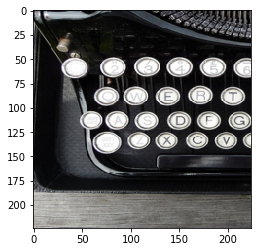

In [7]:
image_batch, cls_batch = next(iter(training_dl))
print(image_batch.shape, image_batch.dtype, image_batch.min(), image_batch.max(), cls_batch.min(), cls_batch.max())
imshow(image_batch[0].permute(1, 2, 0).numpy())

# Creating the Model

Note that we use `layers.Input` to check the size and magnitude of tensors; this is optional.

In [ ]:
from torchvision import models
def make_model():
    return nn.Sequential(
        layers.Input("BDHW", range=(0, 1), sizes=[(2, 9999), 3, 224, 224]),
        models.resnet50()
    )
model = make_model()
model.cuda();

# Training

Note that loading is now very fast (1/10th the time of learning).

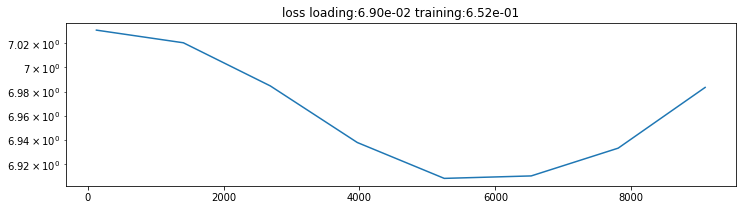

<Figure size 864x216 with 0 Axes>

In [9]:
reload(helpers)
trainer = helpers.Trainer(model)
trainer.set_lr(1e-3)
trainer.train_for(10000, training_dl)
clf()